# Homework 4

## FINM 37400 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# 1 HBS Case: The Information Content of the Yield Curve

## 1.1

The Term Spread
* What is the term spread? 
* What is the preferred measure of the term spread in the case?
* What evidence is cited for the term spread's power in predicting recessions?
* Which is more important, the level of the term spread, its month-over-month change, or the level of short rates?

Using the file `yields_2022-11-30.xlsx`, calculate the term spread as of the end of November 2022. (Measure it with the 10-year and 1-year yields.)
* What does this term spread suggest about economic growth, according to the evidence of Estrella?

## 1.2

Term premia
* What is the term premium? Why is it impossible to get a direct measure of it?
* Explain equations (1) and (2). Why does Sacks think this concept of the term spread complicates the relationship found by Estrella?

## 1.3

Though this case touches on monetary policy, that is not our focus. Rather, our focus is the degree to which the current shape of the yield curve is predictive of future short-term interest rates.

Suppose the term premium is zero. 
* What does an upward sloping yield curve predict about future short-term rates? 
* In this case, is it risky to hold long-term bonds? Is this risk compensated?

Suppose the term premium increases 3 percentage points.
* What would change about your previous answer?

# 2 Calculating Forwards

Use the treasury issues in `'../data/selected_treasury_rates.xlsx.xlsx`. 

The selected treasuries are at nearly six-month intervals. Approximate that they mature at perfect 6-month intervals. (We are looking at them from the perspective of March 31, 2022.)

In [2]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

In [3]:
yield_file = '../data/yields_2022-11-30.xlsx'
yield_data = pd.read_excel(yield_file, index_col=0)
t_file = '../data/selected_treasury_rates.xlsx'
t_data =  pd.read_excel(t_file, index_col=0)

## 2.1 
Bootstrap the discount factor. Plot the answer in terms of discount factors and discount rates.

## 2.2
Calculate the entire forward curve for rates from $T$ to $T+0.5$, ranging $T$ from 0.5 through 6.5.

Plot the forward discount curve.



In [4]:
def calc_cashflows_HW4(quote_data, filter_maturity_dates=False):
    
    CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['TMATDT'].unique())

    for i in quote_data.index:
        coupon_dates = get_coupon_dates(quote_data.loc[i,'CALDT'],quote_data.loc[i,'TMATDT'])

        if coupon_dates is not None:
            CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2
        if quote_data.loc[i,'TMATDT'].day == 31:
            quote_data.loc[i,'TMATDT'] = quote_data.loc[i,'TMATDT'] - pd.DateOffset(1)

        CF.loc[i,quote_data.loc[i,'TMATDT']] += 100


    CF = CF.fillna(0).sort_index(axis=1)
    CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)

    if filter_maturity_dates:
        CF = filter_treasury_cashflows(CF, filter_maturity_dates=True)
        
    return CF

def estimate_curve_ols(CF,prices,interpolate=False):

    if isinstance(prices,pd.DataFrame) or isinstance(prices,pd.Series):
        prices = prices[CF.index].values
    
    mod = LinearRegression(fit_intercept=False).fit(CF.values,prices)

    if interpolate:
        matgrid = get_maturity_delta(CF.columns,CF.columns.min())

        dts_valid = np.logical_and(mod.coef_<1.25, mod.coef_>0)

        xold = matgrid[dts_valid]
        xnew = matgrid
        yold = mod.coef_[dts_valid]

        f = interpolate.interp1d(xold, yold, bounds_error=False, fill_value='extrapolate')    
        discounts = f(xnew)

    else:
        discounts = mod.coef_    
        
    return discounts

def estimate_rate_curve(model,CF,t_current,prices,x0=None):

    if model is bootstrap:
        params = estimate_curve_ols(CF,prices,interpolate=False)
        
        CF_intervals = get_maturity_delta(CF.columns.to_series(),t_current=t_current).values
    
        params_optimized = [CF_intervals,params]

    return params_optimized



In [5]:
t_data['CALDT'] = pd.Timestamp('2022-03-31')
t_data.rename(columns={'maturity date':'TMATDT', 'coupon rate':'TCOUPRT'}, inplace=True)


In [6]:
CF = calc_cashflows_HW4(t_data)

In [7]:
CF

,2022-09-30,2023-03-30,2023-09-30,2024-03-30,2024-09-30,2025-03-30,2025-09-30,2026-03-30,2026-09-30,2027-03-30,2027-09-30,2028-03-30,2028-09-30,2029-03-30
KYTREASNO,,,,,,,,,,,,,,
206896,100.8750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207688,0.0625,100.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207775,0.1250,0.1250,100.1250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207077,1.0625,1.0625,1.0625,101.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207416,0.7500,0.7500,0.7500,0.7500,100.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207507,0.2500,0.2500,0.2500,0.2500,0.2500,100.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207256,1.5000,1.5000,1.5000,1.5000,1.5000,1.5000,101.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207337,1.1250,1.1250,1.1250,1.1250,1.1250,1.1250,1.1250,101.1250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207777,0.4375,0.4375,0.4375,0.4375,0.4375,0.4375,0.4375,0.4375,100.4375,0.0000,0.0000,0.0000,0.0000,0.0000


In [10]:
t_current

Timestamp('2022-03-31 00:00:00')

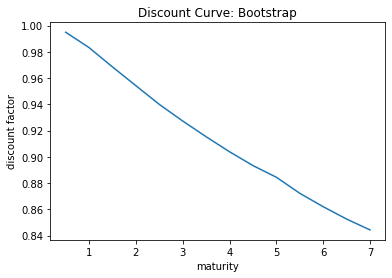

In [11]:
MODEL = bootstrap
DELTA = .5
MULT = 1


RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = True

t_current = t_data['CALDT'].iloc[0]
prices = t_data['price']
params_boot = estimate_rate_curve(MODEL,CF,t_current,prices)

plt.plot(params_boot[0],params_boot[1])
plt.xlabel('maturity')
plt.ylabel('discount factor')
plt.title('Discount Curve: Bootstrap')
plt.show()

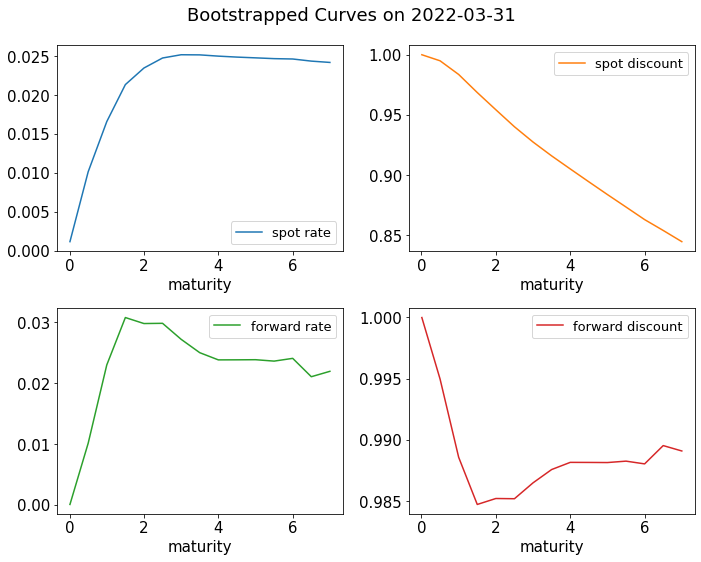

In [10]:
DATES = ['2022-03-31']

curveOLS = extract_spot_curves('2022-03-31', model=bootstrap, delta_maturity=DELTA, T=7, calc_forward=True,delta_forward_multiple=MULT, filter_maturity_dates=True)
fig, ax = plt.subplots(2,2,tight_layout=True,figsize=(10,8))
curveOLS.plot(subplots=True,ax=ax,title=f'Bootstrapped Curves on 2022-03-31')
plt.show()

## 2.3
Use the discount factors to calculate the forward rate from $T_1=2$ to $T_2=2.5$.

Do the same for $T_1=5$ to $T_2=5.5$.


In [17]:
Forward['forward rate'] = pd.DataFrame(-np.log(curveOLS['forward discount'])/0.5)
Forward

,forward discount,forward rate
maturity,,
0.01,0.000023,0.000023
0.50,0.010103,0.010103
1.00,0.022998,0.022998
1.50,0.030812,0.030812
2.00,0.029824,0.029824
2.50,0.029861,0.029861
3.00,0.027225,0.027225
3.50,0.025025,0.025025
4.00,0.023837,0.023837


In [19]:
Forward['forward rate'].loc[2.5]

0.029860885448122015

The forward rate from  𝑇1=2 to  𝑇2=2.5 is 0.0298

In [20]:
Forward['forward rate'].loc[5.5]

0.0236348873825921

The forward rate from  𝑇1=5 to  𝑇2=5.5 is 0.0236


## 2.4
Explain how an FRA between $T_1$ and $T_2$ would function. How is the rate calculated above involved?